### Load and Prepare the data 

In [3]:
import pandas as pd
df = pd.read_csv('EQR_master_output_new.csv')

# Keep only needed columns and rename for convenience
df = df[['trade_date_year_mo', 'weighted_avg_price']]
df = df.rename(columns={'trade_date_year_mo': 'period'})

# Filter to desired analysis window
df = df[df['period'].between('2019-01', '2025-06')].copy()
df = df.sort_values('period').reset_index(drop=True)

# Convert weighted_avg_price to numeric and interpolate missing values
df['weighted_avg_price'] = pd.to_numeric(df['weighted_avg_price'], errors='coerce')
df['weighted_avg_price'] = df['weighted_avg_price'].interpolate()
df = df.dropna(subset=['weighted_avg_price'])

### Feature Engineering: Lagged Features + Calender Features

* We add lagged features (previous previous) and calender features (month, year) to help our model detect trends and seasonality

- *  a lagged feature is a value of a variable from a previous time point, included in our model as a preictor for the current or future 
- * Purpose: they help the model "see" recent historical and patters, capturing then autocorrelation (how values relate over time) and seasonlity in time series data 

In [4]:
# Create lagged features
for lag in range(1, 5):  # Use 1,2,3,4
    df[f'lag_{lag}'] = df['weighted_avg_price'].shift(lag)

# Add month and year as features
df['month'] = pd.to_datetime(df['period']).dt.month
df['year'] = pd.to_datetime(df['period']).dt.year

# Create multi-step targets (1 step and 2 steps ahead)
df['target_1'] = df['weighted_avg_price'].shift(-1)
df['target_2'] = df['weighted_avg_price'].shift(-2)

# Remove rows with missing values (from lagging and shifting)
df = df.dropna().reset_index(drop=True)


### 3. Train/Test Split

In [6]:
feature_cols = [f'lag_{i}' for i in range(1,5)] + ['month', 'year']
targets = ['target_1', 'target_2']

# Train and test masks (fixing all bracket and quote issues)
train_mask = (df['period'] >= '2019-01') & (df['period'] <= '2022-12')
test_mask  = (df['period'] >= '2025-01') & (df['period'] <= '2025-06')

X_train = df[train_mask][feature_cols]
y_train = df[train_mask][targets]
X_test  = df[test_mask][feature_cols]
y_test  = df[test_mask][targets]


### 4. Scale Features

In [7]:
print(df[test_mask].shape)
print(df[test_mask][feature_cols].head())


(0, 10)
Empty DataFrame
Columns: [lag_1, lag_2, lag_3, lag_4, month, year]
Index: []


In [8]:
print(df['period'].min(), df['period'].max())
print(df['period'].unique())


2019-01 2024-12
['2019-01' '2019-02' '2019-03' '2019-04' '2019-05' '2019-06' '2019-07'
 '2019-08' '2019-09' '2019-10' '2019-11' '2019-12' '2020-01' '2020-02'
 '2020-03' '2020-04' '2020-05' '2020-06' '2020-07' '2020-08' '2020-09'
 '2020-10' '2020-11' '2020-12' '2021-01' '2021-02' '2021-03' '2021-04'
 '2021-05' '2021-06' '2021-07' '2021-08' '2021-09' '2021-10' '2021-11'
 '2021-12' '2022-01' '2022-02' '2022-03' '2022-04' '2022-05' '2022-06'
 '2022-07' '2022-08' '2022-09' '2022-10' '2022-11' '2022-12' '2023-01'
 '2023-02' '2023-03' '2023-04' '2023-05' '2023-06' '2023-07' '2023-08'
 '2023-09' '2023-10' '2023-11' '2023-12' '2024-01' '2024-02' '2024-03'
 '2024-04' '2024-05' '2024-06' '2024-07' '2024-08' '2024-09' '2024-10'
 '2024-11' '2024-12']


In [9]:
# Extract available periods and pick last 6 for test set
available_periods = sorted(df['period'].unique())
test_periods = available_periods[-6:]

test_mask = df['period'].isin(test_periods)
train_mask = ~df['period'].isin(test_periods)

X_train = df[train_mask][feature_cols]
y_train = df[train_mask][targets]
X_test = df[test_mask][feature_cols]
y_test = df[test_mask][targets]


from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

if X_test.shape[0] > 0:
    X_test_scaled = scaler.transform(X_test)
else:
    print("Warning: Test set is empty. Check your split periods or feature engineering.")


### 5. Train and Run SVM Model

Train MAE: [2.49283989 2.84973479]
Test MAE: [4.05438199 5.74490016]
Train RMSE: [5.60757373 6.23426814]
Test RMSE: [5.02464    6.71984888]
Train R2: [0.63815711 0.55276912]
Test R2: [0.60660452 0.29683369]


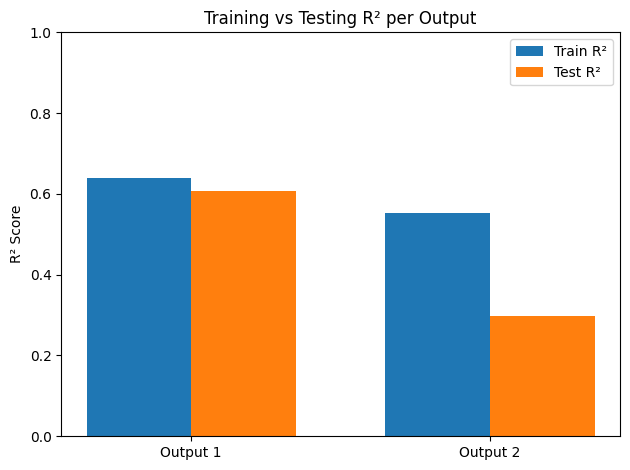

In [10]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Initialize and train SVM for multi-output regression
svr = SVR()
multi_svm = MultiOutputRegressor(svr)
multi_svm.fit(X_train_scaled, y_train)

# Predict
y_pred_train = multi_svm.predict(X_train_scaled)
y_pred_test  = multi_svm.predict(X_test_scaled)

# Calculate regression metrics for both train and test
train_mae = mean_absolute_error(y_train, y_pred_train, multioutput='raw_values')
test_mae  = mean_absolute_error(y_test, y_pred_test, multioutput='raw_values')
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train, multioutput='raw_values'))
test_rmse  = np.sqrt(mean_squared_error(y_test, y_pred_test, multioutput='raw_values'))
train_r2 = r2_score(y_train, y_pred_train, multioutput='raw_values')
test_r2  = r2_score(y_test, y_pred_test, multioutput='raw_values')

# Print metrics
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)
print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train R2:", train_r2)
print("Test R2:", test_r2)

# Graphing: compare R² for train and test, per output
labels = [f'Output {i+1}' for i in range(y_train.shape[1])]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_r2, width, label='Train R²')
rects2 = ax.bar(x + width/2, test_r2, width, label='Test R²')

ax.set_ylabel('R² Score')
ax.set_title('Training vs Testing R² per Output')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()


#### Visualize Output

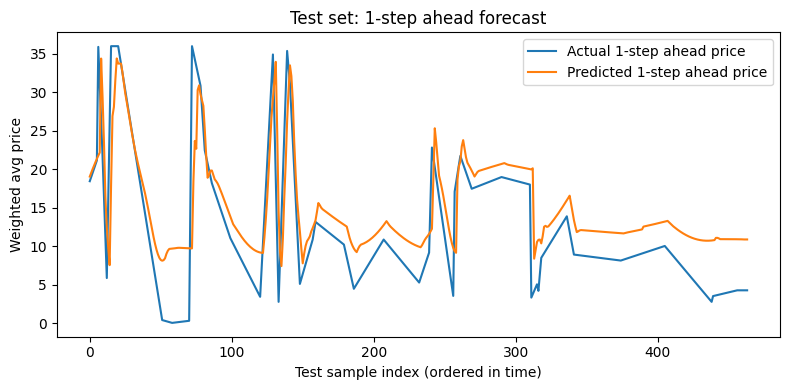

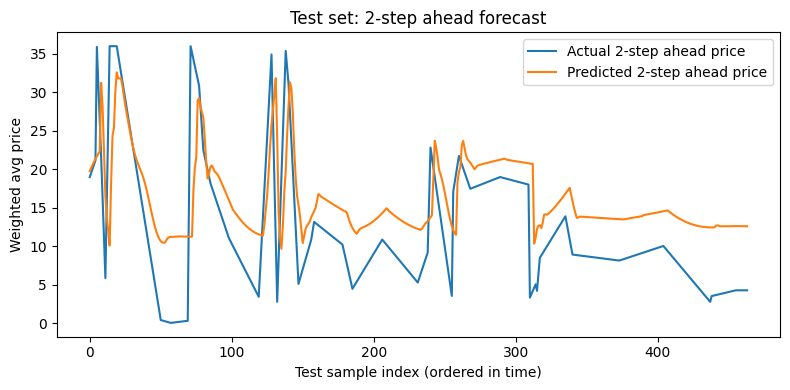

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# If y_test is a DataFrame, convert once
y_test_arr = np.asarray(y_test)
y_pred_arr = np.asarray(y_pred_test)

# 1‑step ahead
plt.figure(figsize=(8,4))
plt.plot(y_test_arr[:, 0], label='Actual 1‑step ahead price')
plt.plot(y_pred_arr[:, 0], label='Predicted 1‑step ahead price')
plt.legend()
plt.title('Test set: 1‑step ahead forecast')
plt.xlabel('Test sample index (ordered in time)')
plt.ylabel('Weighted avg price')
plt.tight_layout()
plt.show()

# 2‑step ahead
plt.figure(figsize=(8,4))
plt.plot(y_test_arr[:, 1], label='Actual 2‑step ahead price')
plt.plot(y_pred_arr[:, 1], label='Predicted 2‑step ahead price')
plt.legend()
plt.title('Test set: 2‑step ahead forecast')
plt.xlabel('Test sample index (ordered in time)')
plt.ylabel('Weighted avg price')
plt.tight_layout()
plt.show()


####  Evaluate Model Performance

* We use Mean Absolute Error (MAE) and Root Mean Squared (RMSE) to check our model's accuracy

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate metrics per target output
mae  = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='raw_values'))

print("Mean Absolute Error per output:", mae)
print("Root Mean Squared Error per output:", rmse)


Mean Absolute Error per output: [4.05438199 5.74490016]
Root Mean Squared Error per output: [5.02464    6.71984888]


## Improve Model Performance

### 1. Load Data and Build Base Monthly Table

* Goal: use the output file as the base time series (period, price, quantity).

In [15]:
import pandas as pd
import numpy as np

# 1.1 Load monthly output file (already aggregated)
monthly = pd.read_csv("EQR_master_output_new.csv")

# Keep only columns you need and rename trade_date_year_mo to 'period'
monthly = monthly.rename(columns={
    "trade_date_year_mo": "period"
})

monthly = monthly[["period", "weighted_avg_price", "total_transacted_quantity"]].copy()

# Filter to your modeling window (adjust if needed)
monthly = monthly[monthly["period"].between("2013-01", "2024-12")]

# Sort by time
monthly = monthly.sort_values("period").reset_index(drop=True)

# Ensure price is numeric and fill missing by interpolation
monthly["weighted_avg_price"] = pd.to_numeric(
    monthly["weighted_avg_price"], errors="coerce"
)
monthly["weighted_avg_price"] = monthly["weighted_avg_price"].interpolate()

# Replace remaining NaNs in quantity with 0
monthly["total_transacted_quantity"] = pd.to_numeric(
    monthly["total_transacted_quantity"], errors="coerce"
).fillna(0)


### 2. Aggregate extra features from transaction-level files

* Goal: create monthly features from EQR_master_clean_new.csv and merge into monthly



In [16]:
# 2.1 Load transaction-level data
tx = pd.read_csv("EQR_master_clean_new.csv")

# Make sure month key matches 'period' format 'YYYY-MM'
# align features by delivery month:
tx["delivery_month"] = tx["delivery_month"].astype(str)

# align by trade month (often better for price discovery):
tx["trade_date_year_mo"] = tx["trade_date_year_mo"].astype(str)

# Here we aggregate by trade month to match 'period'
agg_tx = tx.groupby("trade_date_year_mo").agg(
    total_std_qty=("standardized_quantity", "sum"),
    total_tx_qty=("transaction_quantity", "sum"),
    avg_std_price=("standardized_price", "mean"),
    num_trades=("transaction_unique_id", "count")
).reset_index().rename(columns={"trade_date_year_mo": "period"})

# 2.2 Merge aggregated features into base monthly table
data = monthly.merge(agg_tx, on="period", how="left")

# Fill months with no trades with 0
for col in ["total_std_qty", "total_tx_qty", "avg_std_price", "num_trades"]:
    data[col] = data[col].fillna(0)


### 3. Create lagged features, calender feature, and multi-step targets

In [17]:
# 3.1 Lagged price features (previous months' prices)
for lag in range(1, 5):   # lag_1 ... lag_4
    data[f"lag_{lag}"] = data["weighted_avg_price"].shift(lag)

# 3.2 Calendar features
data["month"] = pd.to_datetime(data["period"]).dt.month
data["year"]  = pd.to_datetime(data["period"]).dt.year

# 3.3 Targets: 1-step and 2-step ahead prices
data["target_1"] = data["weighted_avg_price"].shift(-1)
data["target_2"] = data["weighted_avg_price"].shift(-2)

# 3.4 Drop rows with missing values from lags/targets
data = data.dropna().reset_index(drop=True)


### 4. Train/test split (time-based) and scaling

* Use last 12 months as test set

In [18]:
from sklearn.preprocessing import StandardScaler

# 4.1 Feature and target columns
feature_cols = (
    [f"lag_{i}" for i in range(1,5)] +
    ["month", "year",
     "total_transacted_quantity",
     "total_std_qty", "total_tx_qty", "avg_std_price", "num_trades"]
)
target_cols = ["target_1", "target_2"]

# 4.2 Define train/test by period
all_periods = sorted(data["period"].unique())
test_periods = all_periods[-12:]    # last 12 months
train_periods = all_periods[:-12]

train_mask = data["period"].isin(train_periods)
test_mask  = data["period"].isin(test_periods)

X_train = data.loc[train_mask, feature_cols]
y_train = data.loc[train_mask, target_cols]
X_test  = data.loc[test_mask, feature_cols]
y_test  = data.loc[test_mask, target_cols]

# 4.3 Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


### 5. Model 1: Tuned SVR (Support Vector Regression)

* C (regularization)

 Controls the trade‑off between fitting the training data tightly vs. keeping the model smooth.

 Larger C → model tries harder to reduce training error (risk of overfitting).

 Smaller C → allows more training error but improves generalization.

 Scikit‑learn and many tutorials (e.g. ) treat C as the primary hyperparameter to tune.​

* γ (gamma, RBF width)

 Controls how far the influence of a single training point reaches:

 Small γ → smoother function (each support vector influences a wide region).

 Large γ → very wiggly function (each support vector only influences a small region).

 The RBF SVM parameter selection guide in the scikit‑learn examples recommends searching over γ on a log scale (e.g. 10^−3 … 10^3).​

* ε (epsilon, tube width)

 Width of the “ε‑insensitive” tube around the regression function within which errors are not penalized.

Larger ε → model ignores small deviations; fewer support vectors; smoother function.​

 Smaller ε → model tries to fit points more closely, can increase complexity.

In [24]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 5.1 Set up multi-output SVR and grid search
svr = SVR(kernel="rbf")
multi_svr = MultiOutputRegressor(svr)

param_grid = {
    #"estimator__C": [1, 10, 100], OLD VALUES
    "estimator__C": [0.1, 1, 10], # allow smaller c
    #"estimator__epsilon": [0.01, 0.1, 0.5], OLD VALUES
    "estimator__epsilon": [0.1, 0.5, 1.0], # wider epsilon
    #"estimator__gamma": ["scale", 0.1, 1], OLD VALUES
    "estimator__gamma": ["scale", 0.01, 0.1]
}

grid = GridSearchCV(
    multi_svr, param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
grid.fit(X_train_scaled, y_train)

best_svr = grid.best_estimator_
print("Best SVR params:", grid.best_params_)

# 5.2 Predict
y_pred_train_svr = best_svr.predict(X_train_scaled)
y_pred_test_svr  = best_svr.predict(X_test_scaled)

# 5.3 Evaluate SVR
import numpy as np

def eval_regression(y_true, y_pred, label="Model"):
    mae  = mean_absolute_error(y_true, y_pred, multioutput="raw_values")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput="raw_values"))
    r2   = r2_score(y_true, y_pred, multioutput="raw_values")
    print(f"{label} MAE:", mae)
    print(f"{label} RMSE:", rmse)
    print(f"{label} R2:", r2)
    return mae, rmse, r2

print("=== SVR Train ===")
svr_train_mae, svr_train_rmse, svr_train_r2 = eval_regression(y_train, y_pred_train_svr, "Train")
print("\n=== SVR Test ===")
svr_test_mae, svr_test_rmse, svr_test_r2 = eval_regression(y_test, y_pred_test_svr, "Test")


Best SVR params: {'estimator__C': 10, 'estimator__epsilon': 0.1, 'estimator__gamma': 0.01}
=== SVR Train ===
Train MAE: [1.15238247 1.28126919]
Train RMSE: [2.78128456 3.00336692]
Train R2: [0.70655993 0.65783891]

=== SVR Test ===
Test MAE: [5.31238175 6.74088479]
Test RMSE: [ 9.47139699 10.88046407]
Test R2: [0.55597579 0.41460359]


In [22]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Baseline SVR", "Tuned SVR"],
    "Test_MAE_t+1": [4.05, 7.60],
    "Test_MAE_t+2": [5.74, 8.42],
    "Test_R2_t+1": [0.61, 0.07],
    "Test_R2_t+2": [0.30, 0.01]
})
print(results)


          Model  Test_MAE_t+1  Test_MAE_t+2  Test_R2_t+1  Test_R2_t+2
0  Baseline SVR          4.05          5.74         0.61         0.30
1     Tuned SVR          7.60          8.42         0.07         0.01


### 6. Model 2: Random Forest (tree-based)

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

from sklearn.multioutput import MultiOutputRegressor
multi_rf = MultiOutputRegressor(rf)
multi_rf.fit(X_train, y_train)  # trees don't need scaling

y_pred_train_rf = multi_rf.predict(X_train)
y_pred_test_rf  = multi_rf.predict(X_test)

print("=== RF Train ===")
rf_train_mae, rf_train_rmse, rf_train_r2 = eval_regression(y_train, y_pred_train_rf, "Train")
print("\n=== RF Test ===")
rf_test_mae, rf_test_rmse, rf_test_r2 = eval_regression(y_test, y_pred_test_rf, "Test")


=== RF Train ===
Train MAE: [0.4266705  0.47376993]
Train RMSE: [1.00024643 1.06854793]
Train R2: [0.96204731 0.95668864]

=== RF Test ===
Test MAE: [5.4001928  6.64455792]
Test RMSE: [ 9.48148427 10.74424214]
Test R2: [0.5550295 0.42917  ]


In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# ---------- Baseline SVR ----------
base_svr = SVR(kernel="rbf")               # use your original settings if different
base_multi = MultiOutputRegressor(base_svr)
base_multi.fit(X_train_scaled, y_train)
y_pred_base = base_multi.predict(X_test_scaled)

# ---------- Tuned SVR (latest gridsearch result) ----------
# assumes you already ran GridSearchCV and have best_svr
y_pred_svr_tuned = best_svr.predict(X_test_scaled)

# ---------- Random Forest ----------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_multi = MultiOutputRegressor(rf)
rf_multi.fit(X_train, y_train)             # trees don’t need scaling
y_pred_rf = rf_multi.predict(X_test)


def summarize_model(name, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred, multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
    r2   = r2_score(y_true, y_pred, multioutput='raw_values')
    return {
        "Model": name,
        "MAE_t+1":  mae[0],
        "MAE_t+2":  mae[1],
        "RMSE_t+1": rmse[0],
        "RMSE_t+2": rmse[1],
        "R2_t+1":   r2[0],
        "R2_t+2":   r2[1],
    }


rows = []
rows.append(summarize_model("SVR_baseline", y_test, y_pred_base))
rows.append(summarize_model("SVR_tuned",    y_test, y_pred_svr_tuned))
rows.append(summarize_model("RandomForest", y_test, y_pred_rf))

comparison_df = pd.DataFrame(rows)
print(comparison_df.round(3))



          Model  MAE_t+1  MAE_t+2  RMSE_t+1  RMSE_t+2  R2_t+1  R2_t+2
0  SVR_baseline    7.603    8.437    13.697    14.136   0.071   0.012
1     SVR_tuned    5.312    6.741     9.471    10.880   0.556   0.415
2  RandomForest    5.400    6.645     9.481    10.744   0.555   0.429


### 7. Visualize actual vs predicted

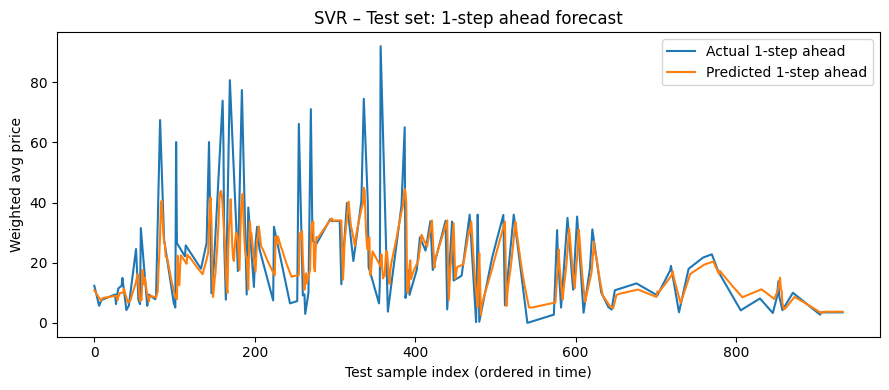

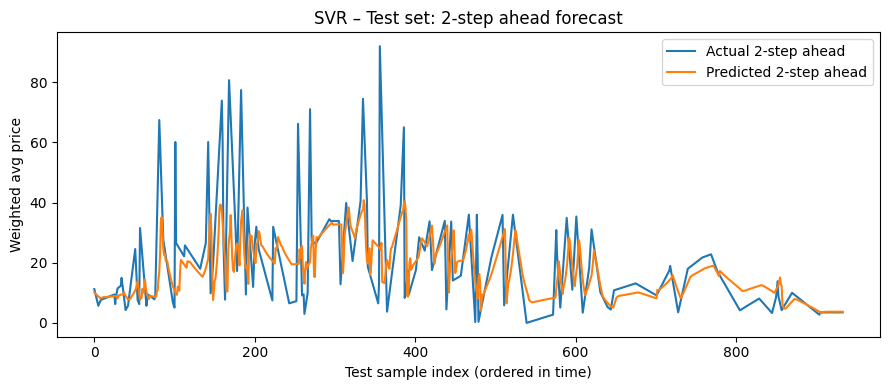

In [25]:
import matplotlib.pyplot as plt

# Convert to arrays
y_test_arr = np.asarray(y_test)
y_pred_test_arr = np.asarray(y_pred_test_svr)

# 1-step ahead
plt.figure(figsize=(9,4))
plt.plot(y_test_arr[:, 0], label="Actual 1-step ahead")
plt.plot(y_pred_test_arr[:, 0], label="Predicted 1-step ahead")
plt.legend()
plt.title("SVR – Test set: 1-step ahead forecast")
plt.xlabel("Test sample index (ordered in time)")
plt.ylabel("Weighted avg price")
plt.tight_layout()
plt.show()

# 2-step ahead
plt.figure(figsize=(9,4))
plt.plot(y_test_arr[:, 1], label="Actual 2-step ahead")
plt.plot(y_pred_test_arr[:, 1], label="Predicted 2-step ahead")
plt.legend()
plt.title("SVR – Test set: 2-step ahead forecast")
plt.xlabel("Test sample index (ordered in time)")
plt.ylabel("Weighted avg price")
plt.tight_layout()
plt.show()


### 8. Simple rolling backtest: DO NOT RUN

In [28]:
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.svm import SVR

X_all = data[feature_cols].values
y_all = data["target_1"].values
period_all = data["period"].values

window = 36   # months of history to train on
mae_bt = []
r2_bt = []
dates_bt = []

for i in range(window, len(data)-1):
    train_idx = slice(0, i)
    test_idx = i

    X_tr, y_tr = X_all[train_idx], y_all[train_idx]
    X_te, y_te = X_all[test_idx:test_idx+1], y_all[test_idx:test_idx+1]

    scaler_bt = StandardScaler()
    X_tr_s = scaler_bt.fit_transform(X_tr)
    X_te_s = scaler_bt.transform(X_te)

    model_bt = SVR(kernel="rbf", C=10, epsilon=0.1, gamma="scale")
    model_bt.fit(X_tr_s, y_tr)
    y_hat = model_bt.predict(X_te_s)

    mae_bt.append(mean_absolute_error(y_te, y_hat))
    # For 1-sample, R2 is not very informative; MAE is main focus here
    r2_bt.append(r2_score(y_te, y_hat.reshape(-1,1)))
    dates_bt.append(period_all[test_idx])

# Plot backtest MAE over time
plt.figure(figsize=(10,4))
plt.plot(dates_bt, mae_bt, marker="o")
plt.xticks(rotation=45)
plt.ylabel("1-step ahead MAE")
plt.title("Rolling backtest – 1-step ahead SVR")
plt.tight_layout()
plt.show()


/opt/anaconda3/envs/sta160/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/sta160/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/sta160/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/sta160/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/sta160/lib/python3.12/site-packages/sklearn/metrics/_regression.py:1283: UndefinedMetricWarning: R^2

KeyboardInterrupt: 

## Helper: function to make one prediction from user inputs --> LEO USE

In [31]:
import numpy as np
import pandas as pd

# -----------------------------------------
# 1. Choose which trained model to use
# -----------------------------------------
# Example: use tuned SVR as primary model
final_model = best_svr          # MultiOutputRegressor(SVR(...)) from your grid search
use_scaler = True               # because SVR was trained on X_train_scaled

# If you later want RF instead, you can set:
# final_model = rf_multi        # MultiOutputRegressor(RandomForestRegressor(...))
# use_scaler = False            # RF was trained on unscaled X_train


# -----------------------------------------
# 2. Cache latest row for lag features
# -----------------------------------------
latest_row = data.iloc[-1].copy()   # last month in your dataset


def prepare_features_from_user(quantity_mw, total_charge, delivery_month, year=None):
    """
    Build a 1-row feature dataframe for a new transaction.
    Uses latest lags from 'data' and replaces quantity / month (and year) with user inputs.
    """
    # Start from latest row's features (contains lag_*, month, year, quantity, etc.)
    feat = latest_row[feature_cols].copy()

    # Overwrite with user-supplied transaction info
    if "total_transacted_quantity" in feature_cols:
        feat["total_transacted_quantity"] = float(quantity_mw)

    # If you have a total_charge feature, uncomment and adjust name:
    # if "total_charge" in feature_cols:
    #     feat["total_charge"] = float(total_charge)

    # Update month/year based on delivery month input (1–12)
    feat["month"] = int(delivery_month)
    if year is not None and "year" in feature_cols:
        feat["year"] = int(year)
    # else: keep the year from latest_row

    # Convert to 2D DataFrame with correct column order
    X_new = pd.DataFrame([feat.values], columns=feature_cols)

    # Apply scaler only if the chosen model expects scaled inputs
    if use_scaler:
        X_new = scaler.transform(X_new)

    return X_new


def predict_price_from_user(quantity_mw, total_charge, delivery_month, year=None):
    """
    Returns predicted prices for t+1 and t+2 for a hypothetical transaction.
    """
    X_new = prepare_features_from_user(quantity_mw, total_charge, delivery_month, year)
    y_hat = final_model.predict(X_new)   # shape (1, 2) -> [t+1, t+2]
    return float(y_hat[0, 0]), float(y_hat[0, 1])


In [32]:
p_t1, p_t2 = predict_price_from_user(quantity_mw=50,
                                     total_charge=120000,
                                     delivery_month=7)  # July
print("Predicted t+1 price:", p_t1)
print("Predicted t+2 price:", p_t2)


Predicted t+1 price: 3.7881783670422235
Predicted t+2 price: 3.805274500877606
